In [1]:
import stompy.model.delft.dflow_model as dfm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import xarray as xr
from stompy import xr_transect as xrt
import os
from stompy import utils
import stompy.plot.cmap as scmap
import numpy as np
%matplotlib notebook

In [7]:
import six
six.moves.reload_module(dfm)

<module 'stompy.model.delft.dflow_model' from '/home/rustyh/src/stompy/stompy/model/delft/dflow_model.py'>

In [2]:
turbo=scmap.load_gradient('turbo.cpt')
hot_cold=scmap.load_gradient('hot_and_cold.cpt')

In [8]:
run_dirs=[#'run_salt_20160520-v104',
          #'run_salt_20160520-v107',
          #'run_salt_20160520-v109',
          #'run_salt_20160520-v110',
          #'run_salt_20160520-v111',
          #'run_salt_20160520-v112', 
          'run_salt_20160520-v113', 
          'run_salt_20160520-v114', 
          'run_salt_20160520-v115', 
          'run_salt_20160520-v116', 
    
    
]

In [9]:
try:
    [h.close() for h in hiss]
except NameError:
    pass
his_fns=[os.path.join(d,'DFM_OUTPUT_flowfm/flowfm_0000_his.nc')
         for d in run_dirs]
hiss=[xr.open_dataset(his_fn) for his_fn in his_fns]
for his,d in zip(hiss,run_dirs):
    his.attrs['run_dir']=d

In [10]:
patt='thalweg_pesc.*'

trans=[dfm.extract_transect_his(his,patt) for his in hiss]

<IPython.core.display.Javascript object>


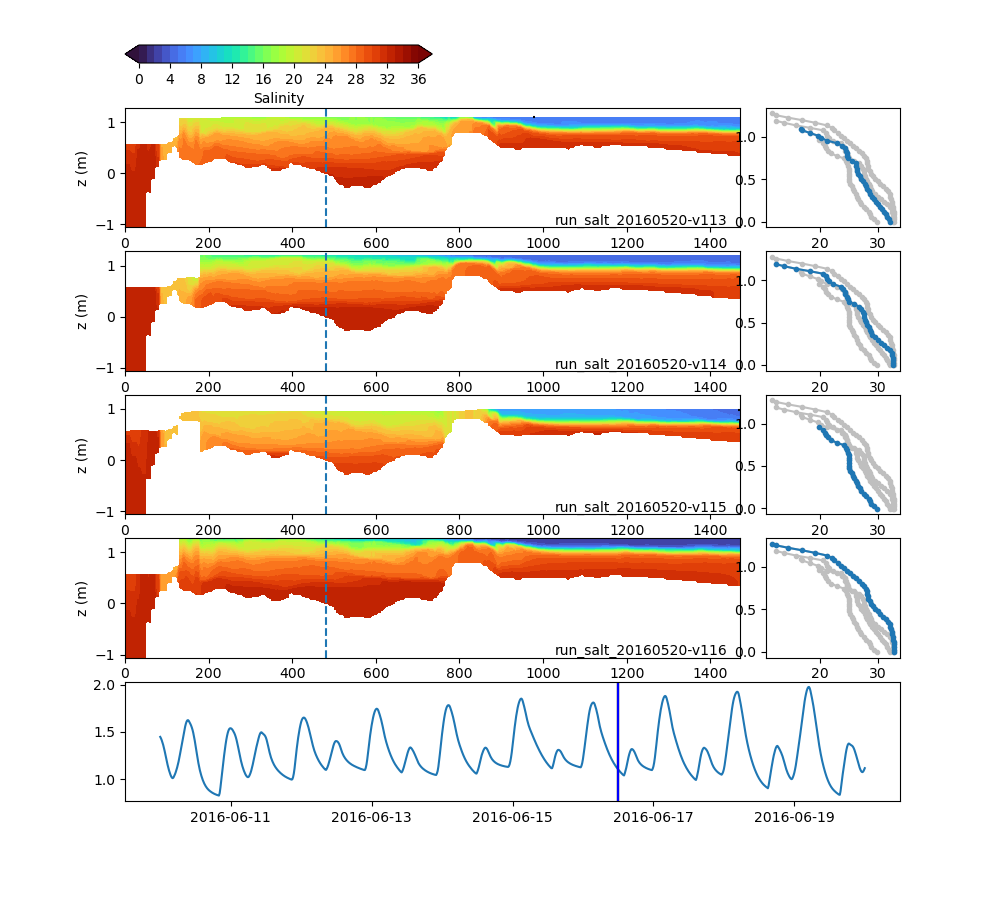

/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  5.544942114773095 32.9876688918032
Range of salinity:  4.367958480632834 32.99926363567171
Range of salinity:  4.48406547235303 32.982503791375315
Range of salinity:  2.0754127564532263 32.978733067432835


In [13]:
fig=plt.figure(figsize=(10,9))

G=gs.GridSpec(1+len(trans),5)

axs=[]
axv=ax=None
axvs=[]
for ti,t in enumerate(trans):
    ax=fig.add_subplot(G[ti,:-1],sharex=ax,sharey=ax)
    axs.append(ax)
    axv=fig.add_subplot(G[ti,-1],sharex=axv,sharey=axv)
    axvs.append(axv)

    
top_pos=axs[0].get_position()

cax=fig.add_axes( [top_pos.xmin,top_pos.ymax+0.05,0.5*top_pos.width,0.02])
    
t=np.datetime64("2016-06-16T12:00")
#t=np.datetime64("2016-06-13T22:00")
#t=np.datetime64("2016-06-12T22:00")
dist=475 # pull a profile from here.
#dist=185 # just inside mouth

V=np.linspace(0,36,37)

ttrans=[tran.isel(
        time=min(np.searchsorted(tran.time.values,t),
                 tran.dims['time']-1) )
     for tran in trans]
    

for ax,tran in zip(axs,ttrans):
    xrt.get_d_sample(tran)
    cset=xrt.contourf(tran,'salinity',V,ax=ax,cmap=turbo,extend='both')
    ax.set_ylabel('z (m)')
    xrt.contour(tran,'salinity',np.r_[33.0],ax=ax,colors='k')
    print("Range of salinity: ",float(tran['salinity'].min()),
          float(tran['salinity'].max()))

plt.colorbar(cset,cax=cax,label='Salinity',orientation='horizontal')

sampxy=None
for ax,axv,tran in zip(axs,axvs,ttrans):
    txy=np.c_[ tran.x_sample.values, tran.y_sample.values]
    if sampxy is None:
        samp=np.searchsorted(tran.d_sample.values,dist)
        sampxy=txy[samp]
    else:
        dists=utils.dist(sampxy, txy)
        samp=np.argmin(dists)
    axv.plot(tran['salinity'].isel(sample=samp),
             tran['z_ctr'].isel(sample=samp),
             marker='.')
    ax.axvline(tran.d_sample.values[samp],ls='--')
    ax.text(0.98,0.02,tran.attrs['run_dir'],transform=ax.transAxes,
            ha='right')
    # ghosted on other axes:
    for ax_other in axvs:
        if ax_other!=ax:
            ax_other.plot(tran['salinity'].isel(sample=samp),
                          tran['z_ctr'].isel(sample=samp),
                          color='0.75',marker='.',zorder=-1)
            

axt=fig.add_subplot(G[-1,:])
axt.plot( hiss[0].time, hiss[0]['waterlevel'].isel(stations=7),label='NCK waterlevel')

for tran in ttrans:
    axt.axvline( tran.time.values,color='k')
    
axt.axvline(t,color='b')

<IPython.core.display.Javascript object>


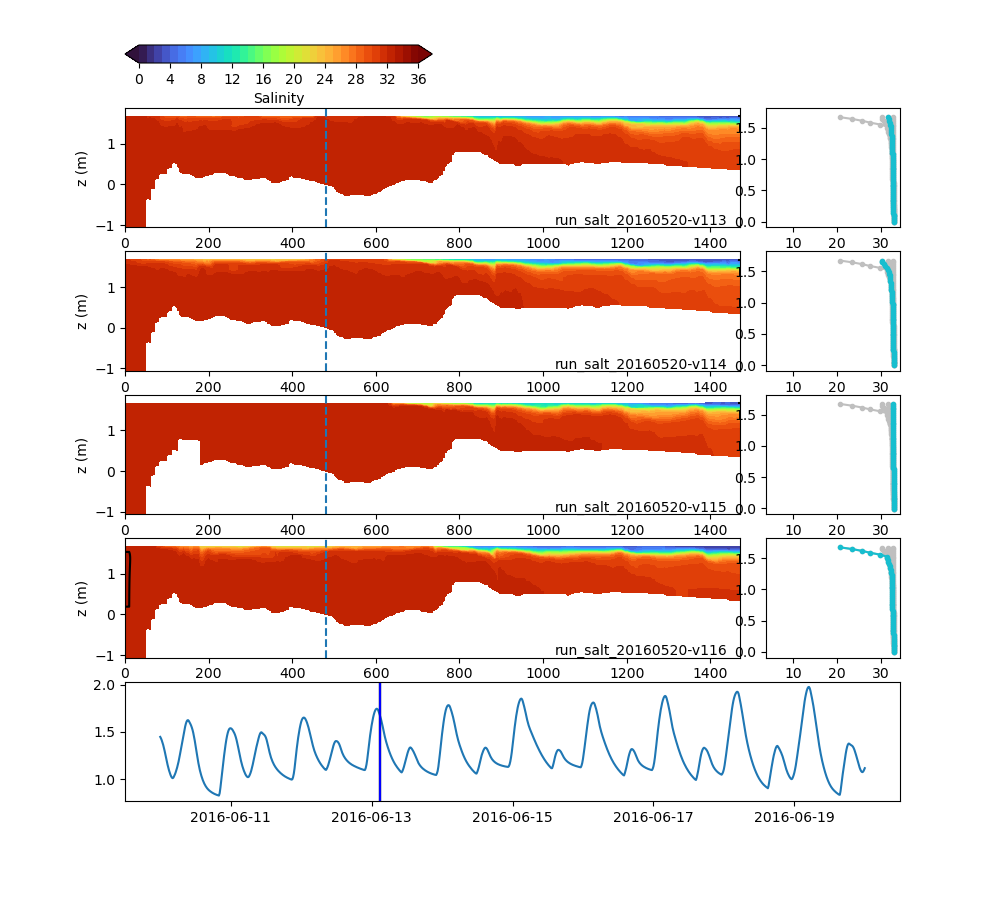

In [76]:
# How to animate those sections:
fig=plt.figure(figsize=(10,9))

G=gs.GridSpec(1+len(trans),5)

axs=[]
axv=ax=None
axvs=[]
for ti,t in enumerate(trans):
    ax=fig.add_subplot(G[ti,:-1],sharex=ax,sharey=ax)
    axs.append(ax)
    axv=fig.add_subplot(G[ti,-1],sharex=axv,sharey=axv)
    axvs.append(axv)
    ax.text(0.98,0.02,t.attrs['run_dir'],transform=ax.transAxes,
            ha='right')
    
top_pos=axs[0].get_position()

cax=fig.add_axes( [top_pos.xmin,top_pos.ymax+0.05,0.5*top_pos.width,0.02])
    
t=np.datetime64("2016-06-16T12:00")
#t=np.datetime64("2016-06-13T22:00")
#t=np.datetime64("2016-06-12T22:00")
dist=475 # pull a profile from here.
#dist=185 # just inside mouth

V=np.linspace(0,36,37)
axt=fig.add_subplot(G[-1,:])
axt.plot( hiss[0].time, hiss[0]['waterlevel'].isel(stations=7),label='NCK waterlevel')

def freeze(fig):
    return [ dict(collections=list(ax.collections),lines=list(ax.lines)) 
             for ax in fig.axes ]
def thaw(fig,state):
    for ax,ax_state in zip(fig.axes,state):
        for k in ax_state:
            setattr(ax,k,list(ax_state[k]))
frozen=freeze(fig)

In [77]:
for t in his.time.values[200:300]:
    draw(t)
    fig.canvas.draw()
    plt.pause(0.01)

/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  3.153751417964936 32.999999653391505
Range of salinity:  2.991720202505432 32.999999831940166
Range of salinity:  3.2291062982544094 32.999981753155915
Range of salinity:  1.7284794356912858 32.9999986905573


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  3.1608565770490995 32.998231286092825
Range of salinity:  2.924155185450276 32.99997938396323
Range of salinity:  3.5669110569260547 32.99897311879798
Range of salinity:  1.967574195025976 32.99999869740914


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  3.184553131299092 32.99957766855753
Range of salinity:  2.8529653918798923 32.999968175469235
Range of salinity:  3.3480220059933843 32.99989058544758
Range of salinity:  2.1690585498999484 33.00001511061065


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.9755959354472568 32.99998492260748
Range of salinity:  2.719823946384905 32.99996352473611
Range of salinity:  3.247586687945135 32.99988449313035
Range of salinity:  2.1954281097223465 32.99996361600774


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.7849795618610496 32.999997039687294
Range of salinity:  2.6081883568005266 32.9999879280807
Range of salinity:  3.111409957041101 32.999965395435176
Range of salinity:  2.1795713465894124 32.999977580005975


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.7468861635745747 32.99987019021367
Range of salinity:  2.744706184829972 32.99999307554254
Range of salinity:  3.1388437796603843 32.999988353276436
Range of salinity:  2.191624430557542 32.99999565179418


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.7757146063121376 32.99986342932729
Range of salinity:  2.744936206096205 32.999995766475564
Range of salinity:  3.0776032069741306 32.999998105764114
Range of salinity:  2.1732549195401583 32.99999877734045


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.852956188669877 32.999928016018735
Range of salinity:  2.8301006895609455 32.99998799874573
Range of salinity:  3.115586155738776 32.99999982422763
Range of salinity:  2.1430512437996287 32.99999850306043


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.9998906319910534 32.99996169049354
Range of salinity:  2.906463531545416 32.99998927664337
Range of salinity:  3.108720544974365 33.000003406966556
Range of salinity:  2.2071925731741873 32.999998496546056


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  3.020788508386074 32.999977931655366
Range of salinity:  2.948154713469562 32.99999366571878
Range of salinity:  3.101932131138133 32.99999958479713
Range of salinity:  2.130795238667905 32.99999499377818


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.9635574734952432 32.99998749132589
Range of salinity:  3.0484196941652884 32.99992254088776
Range of salinity:  3.200544751486183 32.999999643830336
Range of salinity:  2.17497156981365 32.999996383225074


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.990463901545008 32.99999350180024
Range of salinity:  3.0335402732758636 32.999641337918625
Range of salinity:  3.2154413079843045 32.999998179136924
Range of salinity:  2.1738586937332216 32.999987466715275


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  3.0534911476333093 32.99999096597304
Range of salinity:  3.090973277480115 32.999627419980264
Range of salinity:  3.3550498566320606 32.999954392429196
Range of salinity:  2.215818124140563 32.99996734222511


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  3.0758394954318153 32.999995382620085
Range of salinity:  3.170072315007847 32.99995975261753
Range of salinity:  3.542049173146785 32.99995364790874
Range of salinity:  2.1909056320640006 32.999997608305506
Range of salinity:  3.1737118835648928 33.00002038797365
Range of salinity:  3.1770978113789208 32.9999343696844
Range of salinity:  3.555753584447017 32.999989135728974
Range of salinity:  2.276136259783121 32.999999213538516


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  3.320464027754689 33.00001079371258
Range of salinity:  3.2208161545551803 32.993507661496324
Range of salinity:  3.741643502039079 32.99999886398675
Range of salinity:  2.2449870473772093 32.99995008239952


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)
/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  3.3017981608402134 32.99999720988815
Range of salinity:  3.277873764593638 32.995723924262144
Range of salinity:  3.8004500550044993 32.999941721648746
Range of salinity:  2.256860015491457 32.999574147810904


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  3.429884793731534 32.99999908421249
Range of salinity:  3.231391829820532 32.99912786448842
Range of salinity:  3.8144620435667163 32.999433016125906
Range of salinity:  2.315223688237562 32.99970039026465


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  3.33589179718554 32.999816621440985
Range of salinity:  3.1737548236579167 32.999418955941636
Range of salinity:  3.821131888501668 32.99979926724954
Range of salinity:  2.296611659112701 32.99996689457522


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  3.2863171396028905 32.99892669031922
Range of salinity:  3.246782096754349 32.99999434541855
Range of salinity:  3.725736340702644 32.99957498726342
Range of salinity:  2.3587457254392548 32.999818760990024


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  3.3456351056664193 32.999520799287616
Range of salinity:  3.1486270479261496 33.00039351036733
Range of salinity:  3.7666861253357227 32.999163171337756
Range of salinity:  2.3271858165955086 32.99999307548227


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  3.288093370603394 32.99985177450704
Range of salinity:  3.0581848689271256 32.99999699910984
Range of salinity:  3.6588678145439917 32.999827718236254
Range of salinity:  2.3360662205650278 32.99932128336298


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  3.2492930608965036 32.999928953781996
Range of salinity:  2.9945843635226663 32.99990434173526
Range of salinity:  3.6517836898523117 32.99998996453352
Range of salinity:  2.332236673034929 32.998597457849435


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  3.428793236434918 32.99887992191336
Range of salinity:  3.046356944177634 32.99999031385255
Range of salinity:  3.4637279464415265 32.99999707939271
Range of salinity:  2.3553779304361 32.99866860408184


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  3.3634743636478293 32.99921968857516
Range of salinity:  2.993291053969902 32.99983127972294
Range of salinity:  3.3417708249638394 32.99999422864254
Range of salinity:  2.3393264200324952 32.99999889655462


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  3.24039566859986 32.99866822570502
Range of salinity:  2.93513238786896 32.99762983046755
Range of salinity:  3.273276280624469 32.9996619648619
Range of salinity:  2.323704896638305 32.99994224111784


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  3.3055690352623386 32.99999796679468
Range of salinity:  2.8647026148504544 32.99455369691216
Range of salinity:  3.1391942155535553 32.999645002390515
Range of salinity:  2.394692803809497 32.99891071947053


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  3.186817289203964 32.999999995694516
Range of salinity:  2.8362110765671167 32.99343721573781
Range of salinity:  3.0979174839636685 32.999871553695705
Range of salinity:  2.3937898617738185 32.99695118032023


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  3.202332750201546 32.9999999999449
Range of salinity:  2.7423546673825485 32.999488601527325
Range of salinity:  3.047190149113987 32.999969680284984
Range of salinity:  2.400514250453711 32.9971105547277


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  3.090420615686001 32.99999999998891
Range of salinity:  2.819751859754141 32.999994919700704
Range of salinity:  3.0838434373132135 32.99999422572309
Range of salinity:  2.4074124131619903 32.99963757129542
Range of salinity:  3.0411789244200476 33.000011076669075
Range of salinity:  2.786317248173576 32.99999555221784
Range of salinity:  3.0636165849088997 32.999998663405094
Range of salinity:  2.4003569962219458 32.99940744793549


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.9880888008839728 33.000032478779865
Range of salinity:  2.681031459501427 32.99986391556895
Range of salinity:  2.939765651462451 32.99999989453982
Range of salinity:  2.393215635379441 32.999193364044594


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)
/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  3.0181660616551476 32.99999999196415
Range of salinity:  2.645114297381597 32.99967209692437
Range of salinity:  2.8624451050513944 32.999999998407205
Range of salinity:  2.416784979429568 32.99816492864038


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.9857096695576493 32.9999986720567
Range of salinity:  2.6287261500673145 32.9994692757889
Range of salinity:  2.759326174230265 33.00000000015547
Range of salinity:  2.402756177115931 32.999584911546094


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.99859042156595 32.999965937995555
Range of salinity:  2.6011177939358707 32.99947349166361
Range of salinity:  2.652682162516519 33.000000000336556
Range of salinity:  2.419249162560958 32.99999618267474


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.897302630305523 32.999894194938044
Range of salinity:  2.5813005487069622 32.99942629302335
Range of salinity:  2.580705884865236 33.00000390864099
Range of salinity:  2.430959979708619 32.99999992270285


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.9029918322802826 32.99986271116411
Range of salinity:  2.6232558726757014 32.99946544309494
Range of salinity:  2.446381950296971 33.00000555161318
Range of salinity:  2.456306458400413 32.99999999173654


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.8694382740107085 32.99993796543989
Range of salinity:  2.750415761598842 32.99979418426674
Range of salinity:  2.413449901513094 33.000013077058185
Range of salinity:  2.4489464681524495 33.000005002668395


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.7965061950352452 32.999974207624895
Range of salinity:  2.8123965994248463 32.99998579923721
Range of salinity:  2.3594929028272174 33.00002502237021
Range of salinity:  2.46484947768686 32.999999994519115


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.701728328290495 32.999986786147545
Range of salinity:  2.8257629716140245 32.99999331246994
Range of salinity:  2.204851680081056 33.00000183644231
Range of salinity:  2.46348573526794 32.999999992289574


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.6267604845918306 32.99999006988921
Range of salinity:  2.6586013270195004 32.99999409318022
Range of salinity:  1.9014416770088771 33.00000011424083
Range of salinity:  2.4616505736461023 32.99999999155134


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.1544887290961094 32.99999125274163
Range of salinity:  2.651112869219933 32.99999660212186
Range of salinity:  1.6701436608455975 32.99999999999754
Range of salinity:  2.4011534925740907 32.999999993195225


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.112010205312364 32.999991348610564
Range of salinity:  2.536752195459188 32.99999554384032
Range of salinity:  1.2955436707563022 32.99999999998747
Range of salinity:  2.3880699757693264 32.9999999963263


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.8613577651501099 32.99999433687189
Range of salinity:  2.3586515345286583 32.99998640541785
Range of salinity:  1.2448548826626074 32.999999827641055
Range of salinity:  2.3707399996936824 33.000000034185014


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.7697984751143647 32.99999690427307
Range of salinity:  2.296702453458672 32.999921288787064
Range of salinity:  1.1944834099619537 33.000210403174925
Range of salinity:  2.3183683180871286 32.999999998015554


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.8051396757119968 32.9999668486212
Range of salinity:  2.2123669001754047 32.999869913553006
Range of salinity:  1.3175694060639374 32.9999939579235
Range of salinity:  2.143730960537813 32.99999828059044


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.8527598072168565 32.999911468491646
Range of salinity:  2.24444239874203 32.999765823619384
Range of salinity:  1.397072511628864 32.99999038397403
Range of salinity:  2.1125406943143066 32.99999379441224


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.90432481989524 32.99997434427133
Range of salinity:  2.2094736858387884 32.999829571877505
Range of salinity:  1.4792606252183909 32.999997100512225
Range of salinity:  2.0925778019449206 32.99999663167297


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.9228404078275605 32.99999308781889
Range of salinity:  2.268576874296429 32.99989568128991
Range of salinity:  1.5437991485189877 32.999999690951434
Range of salinity:  1.9663645187296834 32.99999784930911


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.004806796307638 32.99995501392351
Range of salinity:  2.2366203431815674 32.999804245662645
Range of salinity:  1.5905799344257574 32.99999979301235
Range of salinity:  1.9036105836171002 32.99981265829233


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.959124021680833 32.999433443491846
Range of salinity:  2.2837102092484294 32.999808508316725
Range of salinity:  1.7314470000065414 32.99998915909953
Range of salinity:  1.9531127992396062 32.99991768889929


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.037612464389299 32.99961782631481
Range of salinity:  2.2495011871238266 32.9994389561771
Range of salinity:  1.9000132065369246 32.99995004155128
Range of salinity:  1.93935383387089 32.99935473333398


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.9553980802831914 32.9995390654188
Range of salinity:  2.183463318025609 32.99860154876125
Range of salinity:  2.066508078527955 32.99994201617874
Range of salinity:  1.9333300789774934 32.999435341842855


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.0226506199056296 32.998645074835686
Range of salinity:  2.115501800652229 32.99942268875708
Range of salinity:  2.2387162073825575 32.999998343953244
Range of salinity:  1.9013117511430724 32.999048457123344


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.9205242529620128 32.998946298386926
Range of salinity:  2.0396489383834533 32.99986206817561
Range of salinity:  2.3380949998170184 32.998700467487154
Range of salinity:  1.882597726330645 32.99916138032222


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.7912523377794292 32.99928794057315
Range of salinity:  1.9554681711975648 32.99992511958221
Range of salinity:  2.5386549017929503 32.99759557143948
Range of salinity:  1.8663183226898519 32.99995440731543


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.884630001054278 32.99966258996802
Range of salinity:  1.8919207311626114 32.99980888701661
Range of salinity:  2.3979876658677957 32.99310969388089
Range of salinity:  1.8792389038710082 32.99942279855744


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.7965058258889492 32.99757856019324
Range of salinity:  1.9695151944317948 32.99971064111979
Range of salinity:  2.5056545387240763 32.995479909012026
Range of salinity:  1.858115364858698 32.998922945955826


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.7431932078712198 32.9970979311276
Range of salinity:  1.9038987910700802 32.9987981162179
Range of salinity:  2.432786165497175 32.99994259846075
Range of salinity:  1.8381437143624024 32.99733789575407


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.6856675706554651 32.999652266188406
Range of salinity:  1.8632857883608875 32.99983808413428
Range of salinity:  2.3965350139899972 32.99945289128655
Range of salinity:  1.814563190981911 32.998124371767624


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.664770655751247 32.9998748636349
Range of salinity:  1.822759169927118 32.99998875863789
Range of salinity:  2.397727453712242 32.999239711734084
Range of salinity:  1.7757407542688803 32.99942569552836


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.7940441634202346 32.999175638783875
Range of salinity:  1.7793744339957618 32.999262016606906
Range of salinity:  2.3168076673385607 32.995036505329765
Range of salinity:  1.7510331761755038 32.999994682664564


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.7486682508972675 32.99863822612534
Range of salinity:  1.7220647335211405 32.998868563677405
Range of salinity:  2.2760852004889163 32.99937352343793
Range of salinity:  1.7141286653531989 32.996614991199266


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.6903916036108027 32.99620796401808
Range of salinity:  1.6756598360418882 32.99906575004788
Range of salinity:  2.200438748946374 32.99987652392592
Range of salinity:  1.6809555943819718 32.99483163740445


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.6270355493165831 32.99745755551287
Range of salinity:  1.6124892840212333 32.996162094063706
Range of salinity:  2.2492887322884316 32.995849572250776
Range of salinity:  1.6646296346851248 32.9947285484952


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.5971223183977188 32.99836875621726
Range of salinity:  1.576998538440302 32.99808593582504
Range of salinity:  2.223498283492007 32.994928296904426
Range of salinity:  1.6608601669293424 32.99487958631926


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.556706185719836 32.999353543253385
Range of salinity:  1.5485788150488877 32.9990357872944
Range of salinity:  2.1771711383677252 32.99434620291356
Range of salinity:  1.7268906822961825 32.99883502033355


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.52550962891809 32.99680350758973
Range of salinity:  1.6844973241192627 32.998921270313225
Range of salinity:  2.067150398148239 32.9980107128276
Range of salinity:  1.675714312845256 32.997881843189376


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.604521806770541 32.99781641538916
Range of salinity:  1.6567303524932526 32.9991264620936
Range of salinity:  1.9790893923634167 32.99913620466357
Range of salinity:  1.6551000211512923 32.99632479595928


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.5972279079526563 32.99260552319132
Range of salinity:  1.591239693253577 32.99829421772922
Range of salinity:  1.901879963103094 32.9970728034935
Range of salinity:  1.6403984668247218 32.994864904450935


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.5821668752771452 32.99620282014277
Range of salinity:  1.557966759294433 32.998256585956796
Range of salinity:  1.810194138003223 32.99564539722267
Range of salinity:  1.6085358613594778 32.99794953956834


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.5906675088354658 32.99575249622617
Range of salinity:  1.526561105427157 32.99936784757272
Range of salinity:  1.8187628010343657 32.99716135383556
Range of salinity:  1.5909220443215184 32.99709741003266


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.5843878296136154 32.99992609050277
Range of salinity:  1.5225106715503909 32.99999797456356
Range of salinity:  1.741990076693171 32.998711078665295
Range of salinity:  1.5838171816392819 32.99696569412695


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.5761245863030657 32.99999957574083
Range of salinity:  1.499695707241499 32.999999717472754
Range of salinity:  1.6633964412663198 32.99856416273802
Range of salinity:  1.5775400049586672 32.997975445320726


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.5610753163405213 32.999597784127054
Range of salinity:  1.462896713047133 32.99958557172258
Range of salinity:  1.6205906089874373 32.99995360069676
Range of salinity:  1.5685513879390836 32.99920515315062


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.5674047111883957 32.99955968510174
Range of salinity:  1.4450829150636937 32.99967350652374
Range of salinity:  1.6383458980286172 32.9999992565433
Range of salinity:  1.5603365030586247 32.99953685967152


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.5893689651920602 32.99844178149117
Range of salinity:  1.4150602531718457 32.999640125543635
Range of salinity:  1.6523125560078884 32.9999996950756
Range of salinity:  1.5487323675413716 32.99971153740247


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.5856849707691154 32.998940141327495
Range of salinity:  1.3856521344838482 32.99935787425353
Range of salinity:  1.6445573247041723 32.99992404358948
Range of salinity:  1.6212001168921315 32.999743758757056


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.6147261093498757 32.999925270240716
Range of salinity:  1.3779875464341997 32.999254896440846
Range of salinity:  1.6482434922802045 32.999691179603715
Range of salinity:  1.6013501689096408 32.99985155443386


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.6261619599747699 32.99999694909259
Range of salinity:  1.3633897343664572 32.998732621512
Range of salinity:  1.6517281101866175 32.99935447533223
Range of salinity:  1.5898025470079573 32.999948990183015


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.6355015330362437 32.99999990095115
Range of salinity:  1.3485257685148202 32.99831200395412
Range of salinity:  1.66126317263723 32.99937810665143
Range of salinity:  1.5814602316251396 32.9999767815419


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.6048480930028173 32.9999999858852
Range of salinity:  1.4121216489420099 32.99999644138417
Range of salinity:  1.73432223765981 32.99908761322517
Range of salinity:  1.5695741600146547 32.99995959373518


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.6134987071961886 32.999999994994354
Range of salinity:  1.428053611359706 32.9999999201804
Range of salinity:  1.9629802961094103 32.999778553391735
Range of salinity:  1.6173087340935604 32.999972463272215


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.6919971699727512 32.9999998088218
Range of salinity:  1.426981627341055 32.99999999018457
Range of salinity:  2.6623881370793807 32.999968607335774
Range of salinity:  1.6174145990985338 32.99998245458293


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.841731922616447 32.99999890739439
Range of salinity:  1.473471067107178 32.9999999968763
Range of salinity:  4.1295020335756405 32.99999586289559
Range of salinity:  1.6109855263381916 32.99998498557369


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.11752644155327 32.999998710242345
Range of salinity:  1.6118864049932744 32.99999999871243
Range of salinity:  3.572008441605862 32.999998728271535
Range of salinity:  1.6644520709046131 32.99997688245797


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.74465365026858 32.99999851726303
Range of salinity:  1.8921481435048593 33.00000000961145
Range of salinity:  3.340098967598089 32.99999938321244
Range of salinity:  1.7318120044319272 32.99999038297381


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  3.2573330593499117 32.999996061067165
Range of salinity:  2.3438549199485084 33.000000019791706
Range of salinity:  2.338095449083939 32.99999978220473
Range of salinity:  1.8837415865625873 32.99999779151936


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  3.064079133837555 32.999996381983465
Range of salinity:  2.8979244819701973 33.00000679054213
Range of salinity:  2.2943045292049034 32.99999998363118
Range of salinity:  1.9375900190020539 32.99999949829669


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.3012098419806657 32.999997519049764
Range of salinity:  3.367333965812751 32.999999773644255
Range of salinity:  2.106453942705826 32.999999998571425
Range of salinity:  1.9761974973784828 32.999999890270395


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.290839829456604 32.99999764002183
Range of salinity:  2.941670322530984 32.999999304440905
Range of salinity:  2.14146065719639 32.99999999973917
Range of salinity:  2.164979352572323 32.99999998193514


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.22545409207814 32.999998643425045
Range of salinity:  2.747916220129013 32.999999496367344
Range of salinity:  1.9274055230963436 32.99999999993106
Range of salinity:  2.0344110764026464 32.99999999673291


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.283359462522384 32.99999989925602
Range of salinity:  2.604527894028423 32.99999923390121
Range of salinity:  1.8085945544776827 32.999999999975174
Range of salinity:  2.0357854925995253 32.999999999138694
Range of salinity:  2.233236289068714 33.00000034758542
Range of salinity:  2.2975184517240885 32.99999939057462
Range of salinity:  2.0536508705723953 32.999999999986834
Range of salinity:  2.0873586713296906 33.00006424615315


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.9399671695374412 33.00000159430749
Range of salinity:  2.2416733843184655 32.99999976388237
Range of salinity:  2.153326683784347 32.99999999998822
Range of salinity:  1.978315891089842 33.00006858337392


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  1.9217816524430325 33.000002768862984
Range of salinity:  2.099493717618673 32.999999908688736
Range of salinity:  2.3338332322626303 33.00000037586302
Range of salinity:  1.9794124650703602 33.00005140727009


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.12633643023204 33.00001840950119
Range of salinity:  1.927395843849409 32.99999995084957
Range of salinity:  2.1166297473943465 33.00000432845786
Range of salinity:  1.7843509585300776 33.00003299625093


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.179147230810193 33.00000069941613
Range of salinity:  2.1734238405801793 32.99999984986864
Range of salinity:  2.1393473824274087 33.000000000215586
Range of salinity:  1.742475528440424 33.00000000030906


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)
/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  2.945832340480297 32.999999660821366
Range of salinity:  2.7846101619105874 32.999998098104044
Range of salinity:  3.1547868404168833 33.00000000077319
Range of salinity:  1.7497964005787683 33.000000000385704


/home/rustyh/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


Range of salinity:  3.0960543318512945 32.999999888465794
Range of salinity:  3.0623154397166923 32.99999392293851
Range of salinity:  3.734433386870767 32.99999999954664
Range of salinity:  2.0639545209782546 33.00000000006827


In [72]:
def draw(t):
    thaw(fig,frozen)
    ttrans=[tran.isel(
            time=min(np.searchsorted(tran.time.values,t),
                     tran.dims['time']-1) )
         for tran in trans]


    for ax,tran in zip(axs,ttrans):
        xrt.get_d_sample(tran)
        cset=xrt.contourf(tran,'salinity',V,ax=ax,cmap=turbo,extend='both')
        ax.set_ylabel('z (m)')
        xrt.contour(tran,'salinity',np.r_[33.0],ax=ax,colors='k')
        print("Range of salinity: ",float(tran['salinity'].min()),
              float(tran['salinity'].max()))

    plt.colorbar(cset,cax=cax,label='Salinity',orientation='horizontal')

    sampxy=None
    for ax,axv,tran in zip(axs,axvs,ttrans):
        txy=np.c_[ tran.x_sample.values, tran.y_sample.values]
        if sampxy is None:
            samp=np.searchsorted(tran.d_sample.values,dist)
            sampxy=txy[samp]
        else:
            dists=utils.dist(sampxy, txy)
            samp=np.argmin(dists)
        axv.plot(tran['salinity'].isel(sample=samp),
                 tran['z_ctr'].isel(sample=samp),
                 marker='.')
        ax.axvline(tran.d_sample.values[samp],ls='--')

        # ghosted on other axes:
        for ax_other in axvs:
            if ax_other!=ax:
                ax_other.plot(tran['salinity'].isel(sample=samp),
                              tran['z_ctr'].isel(sample=samp),
                              color='0.75',marker='.',zorder=-1)



    for tran in ttrans:
        axt.axvline( tran.time.values,color='k')

    axt.axvline(t,color='b')


In [71]:
his.time

<xarray.DataArray 'time' (time: 961)>
array(['2016-06-10T00:00:00.000000000', '2016-06-10T00:15:00.000000000',
       '2016-06-10T00:30:00.000000000', ..., '2016-06-19T23:30:00.000000000',
       '2016-06-19T23:45:00.000000000', '2016-06-20T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-06-10 2016-06-10T00:15:00 ... 2016-06-20
Attributes:
    standard_name:  time